# Assignment 2 for FIT5212, Semester 1, 2020

**Student Name:**  Keerthana Muralitharan

**Student ID:**    30159474

## Part 1 - Recommender Systems
To build a recommendation engine that provides personalized top 10 item recommendations to users based on their interaction with the items.The recommendation system model is built using Implicit Feedback approach( depends on interactions or feedbacks on items made by the users). We would be using **ALternating Least Squares,Logistic Matrix Factorization** and **Bayesian Personalised Ranking** models to build and evaluate the performance of the Recommender systems.

### 1.1 Importing the necessary libraries
Import the packages and libraries which are required to perform the underlying tasks to build a recommender system.

In [1]:
#Importing all the required libraries
#!pip install implicit
import pandas as pd
import numpy as np
import numpy as np

import scipy.sparse as sparse
from sklearn import metrics
import matplotlib.pylab as plt
import random
import implicit

### 1.2 Loading the data

The train,test and validation data is being read and stored in the form of a dataframe using pandas.The validation dataframe is being combined with the train dataframe and used for further processing.

In [2]:
# Load the data into a dataframe
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
validation = pd.read_csv('validation_data.csv')


#The data from the vaidation dataframe with ratings value equal to 1 is filtered
interacted_valid=validation[validation['rating']==1]

#Final dataframe is created with combining the train dataframe and filtered validation dataframe
data =train.append(interacted_valid)

#display the dimensions of the datasets
print('Dimension of the train data set is ',train.shape)
print('Dimension of the test data set is ',test.shape)
print('Dimension of the validation data set is ',validation.shape)
print('Dimension of the new data set is ',data.shape)

Dimension of the train data set is  (28449, 3)
Dimension of the test data set is  (223900, 2)
Dimension of the validation data set is  (223900, 3)
Dimension of the new data set is  (30688, 3)


In [3]:
#Display the number of users and items present in the dataframe
print('Total number of users:',len(data['user_id'].unique()))
print('Total number of items:',len(data['item_id'].unique()))

Total number of users: 2239
Total number of items: 2174


### 1.3 Creating sparse matrices

Here we build two sparse matrices one is used for fitting the model(item-user) and the other is used for recommendations(user-item) because the implicit library wants the input data to be in the format of sparse matrix.

In [4]:
# The data is converted into an item-user matrix for fitting the model
sparse_item_user = sparse.csr_matrix((data['rating'].astype(float), (data['item_id'], data['user_id'])))

# The data is converted into an user-item matrix for recommending items to the user from the built model
sparse_user_item = sparse.csr_matrix((data['rating'].astype(float), (data['user_id'], data['item_id'])))

### 1.4 Checking the sparsity of the data

Sparse data in Machine Learning alters the performance and the ability of machine learning algorithms to calculate accurate predictions. Data is called sparse when some predicted values are missing in a data set, which is a common phenomenon in general large-scale analyses of data. Here we get a  sparsity of **99.36%** , which is very huge infering that there are many values are sparse.

###### Reference : http://www.diva-portal.se/smash/get/diva2:1111045/FULLTEXT01.pdf

In [5]:
# Number of possible interactions in the matrix
matrix_size = sparse_user_item.shape[0]*sparse_user_item.shape[1] 

# Number of items interacted with
num_purchases = len(sparse_user_item.nonzero()[0]) 

#Finding the sparsity 
sparsity = 100*(1 - (num_purchases/matrix_size))
print("Sparsity :",sparsity)

Sparsity : 99.36954375331017


### 1.5 Splitting into train and test datasets

The below function is used in take in the original user-item matrix and cover up a small percentage of the ratings where an
user-item interaction has taken place for use as a test set.This altered list of users for with a small percentage of ratings for which the data is being masked.

**Function Process**
- Take a copy of the test set ratings and store it as a binary preference matrix
- Find the ratings which is equal to 1 and combine the user_id and items pairs
- Slecting random number of rows without any replacement or masking
- Get the item row index values and user column index values of the samples created in previous step
- Set the value zero to the user-item pairs which are randomly chosen and remove the zeros the sparse array
- Return the training and test set of ratings and the altered list of distinct users.

In [6]:
#https://github.com/akhilesh-reddy/Implicit-data-based-recommendation-system/blob/master/Implicit%20data%20based%20recommendation%20system%20using%20ALS.ipynb

def make_train(ratings, percentage_to_mask):
    
    #set random seed for reproducibility
    random.seed(0)
    
    #store the test set ratings as a binary preference matrix
    training_set = ratings.copy()
    test_set = ratings.copy() 
    test_set[test_set != 0] = 1 
    
    #- Find the ratings which is equal to 1 and combine the user_id and items ratings
    nonzero_inds = training_set.nonzero() 
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 
    num_samples = int(np.ceil(percentage_to_mask*len(nonzero_pairs))) 
    
    #select a random  number of samples without masking
    samples = random.sample(nonzero_pairs, num_samples) 

    #Store the item and user indices from the samples
    item_inds = [index[0] for index in samples] 
    user_inds = [index[1] for index in samples] 

    #Assign 0 to all user-item pairs which are randomly chosen and update the sparse array 
    training_set[item_inds, user_inds] = 0 
    training_set.eliminate_zeros() 
    
    return training_set, test_set, list(set(user_inds))

In [7]:
# 20% of the data has been masked for this exercise
split_train, split_test, masked_users = make_train(sparse_item_user, percentage_to_mask = 0.05)

### 1.6 Calculating the AUC score using Bayesian Personalized Ranking

###### Reference : https://towardsdatascience.com/recommender-system-using-bayesian-personalized-ranking-d30e98bba0b9#:~:text=Instead%20it%20optimizes%20to%20predict,personalized%20rankings%20for%20each%20user.

Bayesian Personalised Ranking is used to provide the user with a ranked list of items

The below function is used to find the area below the ROC curve - Receiver Operating Characteristic using the prediction output and actual result.

The second function is to calculate the mean AUC to evaluate the recoomendation System for any given user with the users with masked ratings from their user-item sparse matrix.

**Function Process**
- store the AUC scores for the users for which the items were removed.
- Calculate the sum of the interactions between the user and item to find the most popular items for the user.
- For every altered user, find the interactions that has not occurred
- Calculate the predicted values based on the user-item vectors
- Select all ratings from the MF prediction for this user that originally had no interaction
- Calculate the AUC for the given users
- Return the mean AUC score for user.

In [11]:
# https://github.com/akhilesh-reddy/Implicit-data-based-recommendation-system/blob/master/Implicit%20data%20based%20recommendation%20system%20using%20ALS.ipynb

#Function to calculate the mean AUC by user for any user in the user_item matrix which was altered.
def calc_mean_auc(training_set, masked_users, predictions, test_set):

    #Create empty lists to store the AUC scores for each user.
    store_auc = [] 
    item_vecs = predictions[1]
    
    # Find where the interaction had not occurred for every altered user
    for user in masked_users: 
        training_column = training_set[:,user].toarray().reshape(-1) 
        zero_inds = np.where(training_column == 0) 
        
        # Calculate the predicted values based for user-item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
        
        # Calculate AUC for the given user
        fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
        store_auc.append(metrics.auc(fpr, tpr)) 
        
    # Return the mean AUC for test
    return float('%.3f'%np.mean(store_auc))  
   

### 1.7 Finding the best parameters for the model

The parameters used to build the model are 
- alpha
- factor
- iterations
- regularisation factor

Using the **Alternating Least Squares**,**Logistic Matrix Factorization**,**Bayesian Personalised Ranking** the model is being built and using **Bayesian Personalised Ranking** the AUC is calculated and the user is provided with the ranked list of items.

AFter the model is built using ALS,LMF and BPR and data is fitted to it, we would optimise the performance using BPR by extracting the **item_vector** and **user_vector** matrix and finding the AUC score

In [28]:

#Create empty lists to store the parameters of the model
iteration=[]
regu=[]
fact=[]
AUC_score=[]
alpha_val=[]

#iterate to find the best values of the model by changing the parameters and building the model
for alpha1 in range(20,40,10):
    
    #making the data 
    data_conf = (split_train * alpha1).astype('double')
    
    #iterating over factors,regularization and iterations to find the best model
    for fac in range(7,10,1):
        for reg in np.arange(0.15,0.2,.05):
            for itera in range(30,35,5):
                np.random.seed(0)
                #Building the ALS Model
                model = implicit.als.AlternatingLeastSquares(factors=fac, regularization=reg, iterations=itera)
                model.fit(data_conf)
                
                ## BAYESIAN PERSONALISED RANKING
                #extracting the item_vector matrix and user_vector matrix that we have created through the model
                item_vecs = model.item_factors
                user_vecs = model.user_factors
                
                # Calculate the AUC SCore
                AUC = calc_mean_auc(split_train, masked_users,
                                  [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], split_test)
                
                #Extract the values and store in the appropriate lists
                best_score=AUC
                iteration.append(itera)
                regu.append(reg)
                fact.append(fac)
                alpha_val.append(alpha1)
                AUC_score.append(best_score)      

                
## Store the values of the parameters into a dataframe
als_model=percentile_list = pd.DataFrame(
    {'iteration': iteration,
     'regularization': regu,
     'factor': fact,
     'alpha':alpha_val,
     'AUC':AUC_score,
     'Method':'ALS'
    })

In [29]:

#Create empty lists to store the parameters of the model
iteration=[]
regu=[]
fact=[]
AUC_score=[]
alpha_val=[]

#iterate to find the best values of the model by changing the parameters and building the model
for alpha1 in range(20,40,10):
    
    #making the data 
    data_conf = (split_train * alpha1).astype('double')
    
    #iterating over factors,regularization and iterations to find the best model
    for fac in range(7,10,1):
        for reg in np.arange(0.15,0.2,.05):
            for itera in range(30,35,5):
                np.random.seed(0)
                #Building the LMF Model
                model = implicit.lmf.LogisticMatrixFactorization(factors=fac, regularization=reg, iterations=itera)
                model.fit(data_conf)
                
                ## BAYESIAN PERSONALISED RANKING
                #extracting the item_vector matrix and user_vector matrix that we have created through the model
                item_vecs = model.item_factors
                user_vecs = model.user_factors
                
                # Calculate the AUC SCore
                AUC = calc_mean_auc(split_train, masked_users,
                                  [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], split_test)
                
                #Extract the values and store in the appropriate lists
                best_score=AUC
                iteration.append(itera)
                regu.append(reg)
                fact.append(fac)
                alpha_val.append(alpha1)
                AUC_score.append(best_score)      

                
## Store the values of the parameters into a dataframe
lmf_model=percentile_list = pd.DataFrame(
    {'iteration': iteration,
     'regularization': regu,
     'factor': fact,
     'alpha':alpha_val,
     'AUC':AUC_score,
     'Method':'LMF'
    })


In [30]:

#Create empty lists to store the parameters of the model
iteration=[]
regu=[]
fact=[]
AUC_score=[]
alpha_val=[]


#iterate to find the best values of the model by changing the parameters and building the model
for alpha1 in range(20,40,10):
    
    #making the data 
    data_conf = (split_train * alpha1).astype('double')
    
    #iterating over factors,regularization and iterations to find the best model
    for fac in range(7,10,1):
        for reg in np.arange(0.15,0.2,.05):
            for itera in range(30,35,5):
                np.random.seed(0)
                #Building the BPR Model
                model = implicit.bpr.BayesianPersonalizedRanking(factors=fac, regularization=reg, iterations=itera)
                model.fit(data_conf)
                
                ## BAYESIAN PERSONALISED RANKING
                #extracting the item_vector matrix and user_vector matrix that we have created through the model
                item_vecs = model.item_factors
                user_vecs = model.user_factors
                
                # Calculate the AUC SCore
                AUC = calc_mean_auc(split_train, masked_users,
                                  [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], split_test)
                
                #Extract the values and store in the appropriate lists
                best_score=AUC
                iteration.append(itera)
                regu.append(reg)
                fact.append(fac)
                alpha_val.append(alpha1)
                AUC_score.append(best_score)      

                
## Store the values of the parameters into a dataframe
bpr_model=percentile_list = pd.DataFrame(
    {'iteration': iteration,
     'regularization': regu,
     'factor': fact,
     'alpha':alpha_val,
     'AUC':AUC_score,
     'Method':'BPR'
    })


In [31]:
best_model=pd.DataFrame()
best_model=best_model.append([als_model,lmf_model,bpr_model])


In [36]:
#Display the dataframe with the parameters and the AUC scores.
best_model = best_model.sort_values(by =['AUC'], ascending=False)
best_model.head(15)

,iteration,regularization,factor,alpha,AUC,Method
6,30,0.15,7,30,0.794,ALS
7,30,0.20,7,30,0.794,ALS
0,30,0.15,7,20,0.793,ALS
1,30,0.20,7,20,0.793,ALS
8,30,0.15,8,30,0.789,ALS
9,30,0.20,8,30,0.789,ALS
3,30,0.20,8,20,0.788,ALS
2,30,0.15,8,20,0.788,ALS
11,30,0.20,9,30,0.788,ALS
10,30,0.15,9,30,0.788,ALS


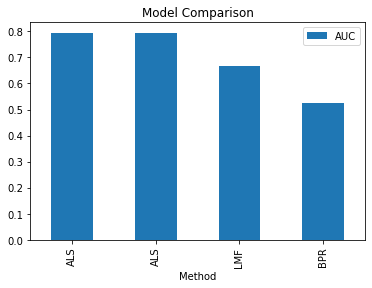

In [95]:
als=best_model[best_model['Method']=='ALS']
lmf=best_model[best_model['Method']=='LMF']
bpr=best_model[best_model['Method']=='BPR']
als=als[als["AUC"]==als["AUC"].max()]
lmf=lmf[lmf["AUC"]==lmf["AUC"].max()]
bpr=bpr[bpr["AUC"]==bpr["AUC"].max()]

new_model=pd.DataFrame()
new_model=new_model.append([als,lmf,bpr])

new_model.plot.bar(x='Method', y='AUC', rot=90, title="Model Comparison")


### 1.8 Building the model with the best parameters

From the above evaluation we could find that the model with values for 
- **alpha=30**,
- **factors=7**,
- **regularization=0.15**,
- **iterations=30** 
- **method=ALTERNATING LEAST SQAURES**
have the best **AUC score** and **NDCG score in KAGGLE**

With these values we have built an ALS model and it is fitted with the data 

In [14]:
#setting random seed to produce reproducibility in the code
np.random.seed(0)

alpha=30
data_new=(sparse_item_user*alpha).astype('double')


#Building the model with ALS
model = implicit.als.AlternatingLeastSquares(factors=5, regularization=0.15, iterations=30,num_threads=0)
model.fit(data_new)

In [15]:
# Extract the item and user vector from the model built
item_vecs = model.item_factors
user_vecs = model.user_factors

print('Dimensions of Item vector matrix : ', item_vecs.shape)
print('Dimensions of User vector matrix : ', user_vecs.shape)

Dimensions of Item vector matrix :  (2174, 5)
Dimensions of User vector matrix :  (2239, 5)


In [16]:
AUC = calc_mean_auc(split_train, masked_users,
                                  [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], split_test)

In [17]:
AUC

0.888

### 1.9 Item Recommendation

Using the above ALS model we can recommend the items for all the users, The top 10 items are then extracted by comparing the test data provided and scores which is obtained from the recommend() function.

In [39]:
#create Empty dataframes
recommendations=pd.DataFrame()
recom=pd.DataFrame()


# Create recommendations for every user with item id
Num_recom=len(train['user_id'].unique())
Num_items=len(train['item_id'].unique())


for user in range(Num_recom):

    # Use the implicit recommender to recommend all the items to the users
    recommended = model.recommend(user, sparse_user_item,N = Num_items,filter_already_liked_items = False)

    items = []
    scores = []

    # Get item_id from the recommended values (tuple consisting of the item_id and its score)
    items = [a_tuple[0] for a_tuple in recommended]
    
    #Take a list of item_id for every user present in the test dataset
    samp=test[test['user_id']==user]['item_id'].values.tolist()
    
    # Create a dataframe of item id and user id
    s = set(samp)
    final=[x for x in items if x in s]
    
    #Extract only top 10 items for every user
    final=final[:10]
    
    #store user id and item id in the dataframe
    recom['user_id']=user
    recom['item_id']=final
    
    #Append the user id and item id into a dataframe
    recommendations=recommendations.append(recom)




In [40]:
#The null values are replaced and the datatype of the column in the dataframe is converted to integer
recommendations=recommendations.fillna((train['user_id'].min()))
recommendations=recommendations.astype('int64')

print("Dimension of the recommendation dataframe :", recommendations.shape)

print("\nSnippet of the dataframe:\n")
recommendations.head(10)

Dimension of the recommendation dataframe : (22390, 2)

Snippet of the dataframe:



,user_id,item_id
0,0,555
1,0,893
2,0,558
3,0,1128
4,0,156
5,0,1766
6,0,150
7,0,1862
8,0,239
9,0,1363


### 1.10 Storing the results

The top 10 items for every user is recommended and the data frame is written into a csv file, which is submitted to kaggle to find the ndcg score.

In [41]:
#The result is written into a csv file 
recommendations.to_csv('30159474.csv', index = False)

## Part 2:  Node Classification in Graphs

The given task is to classify the nodes in the given graph which is a citation network graph. The nodes in the graph are the papers, the edges in the graph is the relationship between two papers(nodes). The node classification is done based on the labels provided.


### 2.1 Importing the necessary libraries
Import the packages and libraries which are required to perform the underlying tasks.

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd

from node2vec import Node2Vec

import warnings
from collections import deque
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk import word_tokenize    
from sklearn.svm import LinearSVC, SVC
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef



### 2.2 Creating the graph 

A graph with nodes(papers) and edge(relationship between the papers).

In [43]:
# creating an empty graph with 0 nodes and 0 edges
G = nx.Graph()

In [44]:
#display the nodes and edges for the graph G 
print(G.nodes())
print(G.edges())

#display the type of the nodes and edges
print(type(G.nodes()))
print(type(G.edges()))

[]
[]
<class 'networkx.classes.reportviews.NodeView'>
<class 'networkx.classes.reportviews.EdgeView'>


#### 2.2.1 Reading the nodes
The nodes are read from the docs.txt and the title and node_id is stored in the dataframe.

In [45]:
#Read the data from the docs file store the content of node_id and title
node_id=[]
node_content=[]
node_data=pd.DataFrame()

with open('docs.txt','r',encoding='utf-8') as nodes:
    for line in nodes.readlines():
        node_id.append(line.split(' ')[0])
        node_content.append(' '.join(line.split()[1:]))

#store the node_id and title in the dataframe
node_data['Node_id']=node_id
node_data['Title']=node_content

#### 2.2.2 Reading the edges

The adjacent edges are read from the adjedges.txt file and the first node is the source node and the rest nodes in the line are the destination nodes.

- The lines which has one node denotes it doesnot have any connections with other nodes
- The lines which has 2 nodes denotes there is one source and only one destination
- The rest of the lines denote that the source node has many connections to different destination nodes

After which the list with tuples is created with the source and destination nodes to represent each and every connection.

In [46]:
#https://kite.com/python/answers/how-to-convert-each-line-in-a-text-file-into-a-list-in-python

#Read the adjacent edges file in read mode
a_file = open("adjedges.txt", "r")

edges = []
for line in a_file:
    stripped_line = line.strip()
    line_list = tuple(stripped_line.split())
    edges.append(line_list)

a_file.close()


In [47]:
#https://stackoverflow.com/questions/14616519/how-to-remove-a-list-within-list-based-on-len-in-python

#List containing only nodes which have edges
edge = [x for x in edges if len(x)  >1]

# list which containing only  one edge between the source and destination
edge1 = [x for x in edge if len(x) ==2]

#list containing nodes which has more than one edge from one single source node
edge2 = [x for x in edge if len(x) > 2]

In [48]:
#Edge list is used to create a list of tuples in each with the source and destination in each tuple.

edgelist=[]
for val in range(0,len(edge2)):
    tupedge=edge2[val]
    for i in range(0,len(tupedge)-1):
        tup=(tupedge[0],tupedge[i+1])
        edgelist.append(tup)

In [49]:
#concatenating the list of tuples from the source with one destination and many destinations into one list
adjedge=edge1+edgelist

#### 2.2.3 Generating the graph

The nodes and edges are added to the empty graph from the node_id and list of tuples with source and detination edges without any duplicate entries using the set datatype.There are totaaly **54183** edges and **36928** nodes in the graphs.

In [50]:
#adding the nodes and edges without duplicate entries
G.add_nodes_from(set(node_id))
G.add_edges_from(set(adjedge))

In [51]:
#display the nodes and edges for the graph G 
print("Number of edges:",G.number_of_edges())
print("Number of nodes:",G.number_of_nodes())

#display the type of the nodes and edges
print(type(G.nodes()))
print(type(G.edges()))

Number of edges: 54183
Number of nodes: 36928
<class 'networkx.classes.reportviews.NodeView'>
<class 'networkx.classes.reportviews.EdgeView'>


#### 2.2.4 Reading the nodes for classification

The nodes which are needed to classified is read into the dataframe with the labels.

In [52]:
#Read the data from the labels.txt file and store in dataframe
labels_data =  pd.read_csv('labels.txt', sep='\s',header = None)
labels_data.columns = ['Node', 'Label']
labels_df = labels_data.astype(str)
labels_df


#Take the list of nodes from the dataframe.
label_node=[labels_df['Node']]


### 2.3  Embedding

#### 2.3.1 Node2Vec Implementation
Node2Vecis used in mapping the nodes to low-dimensional embeddings
Node Embedding is performed to encode nodes so that similarity in the embedding space like the dot product approximates to the similarity in the graph network.

Node2vec model is built for the graph G with 32 dimensions, 20 walk_length with 50 walks.

The **x** holds the 32 dimensional input features and **y** holds the corresponding target values.

Basically the window size is set as 10 for deepwalk and Batch_words=4 gives better vectors 
###### Reference : http://snap.stanford.edu/proj/embeddings-www/files/nrltutorial-part1-embeddings.pdf

In [53]:
#pre-compute the probabilities and generate walks :
node2vec = Node2Vec(G, dimensions=32, walk_length=20, num_walks=50)


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [20:12<00:00, 24.25s/it]


In [54]:
#embed the nodes by fitting the model using Node2Vec
embed_node = node2vec.fit(window=10, min_count=1, batch_words=4)

In [55]:
embed_node

In [56]:
#The nodes which are present in the labels dataframe are filtered from the embedded nodes.
x = embed_node.wv[labels_df['Node']].tolist()

#Labels are converted into a list the target values
y = labels_df['Label'].tolist()

#### 2.3.2 Text Embedding

The titles of the paper(node) is being embedding using the **TF_IDF** vectorizer by preprocessing and tokenising the titles of the nodes.The stopwords in the titles are removed , document frequency is not considered as it is the title and not a big document as is set as it is generally used.Use of ngrams is not necessary as it is title.

In [57]:
#doing the Lemmatization using wordnet lemmatization
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    

In [58]:
import string

In [59]:
#Create a list of stopwords  and punctuation 
final_stopwords_list=stopwords.words('english')+list(string.punctuation)

# Creating a Vectorizer to convert the strngs into tokens
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern='(?u)\\b\\w\\w+\\b', 
                           stop_words=final_stopwords_list,
                           tokenizer=LemmaTokenizer()
                          )

In [60]:
#Get the Title into the list to transform using the vectorizer
trainTitle = node_data['Title'].tolist() 
vectorized=vectorizer.fit_transform(trainTitle)

#Convert the Node2Vec embedded nodes into an array
X1=np.array(x)

In [61]:
print("Dimensions of the embedded vectors:",X1.shape)

Dimensions of the embedded vectors: (18720, 32)


### 2.3.3 Stacking the embedding results

Hstack is used to horizontally stack sparse matrices of the results of text and node embedding.

In [62]:
#the results of the text and node embedding is stacked horizontaly(column-wise) and it returns a CSR matrix.
Xfull=hstack((vectorized,X1),format='csr')

### 2.4 Splitting the Train and Test dataset

The csr matrix is divided into train and test dataset into the **20:80** ratio and **seed** is set using the **random_state** which is an integer that sets the seed for the random number generator during the train and test split.This is because typically for node classification in any given network, we only have a small number of training data. The 3 types data(node embedding,text embedding and the stacked embedding) is split into train and test data to know the best accurate ones.

In [63]:
#https://medium.com/@contactsunny/how-to-split-your-dataset-to-train-and-test-datasets-using-scikit-learn-e7cf6eb5e0d
np.random.seed(0)
#The network is being split into train and test datasets.
x_train_full,x_test_full,y_train_full,y_test_full = train_test_split(Xfull,y,train_size = 0.2,random_state=None)
x_train_text,x_test_text,y_train_text,y_test_text = train_test_split(vectorized,y,train_size = 0.2,random_state=None)
x_train_node,x_test_node,y_train_node,y_test_node = train_test_split(X1,y,train_size = 0.2,random_state=None)

### 2.5 Model Comparison

Four different traditional models are built and tested using Cross-validation for 5 folds to identify the best fit model for the classification task. Methods selected are SGD Classifier, SVC, Linear SVC and Random Forest. These models are built for all of the network train data and one of the model which has higher accuracy is selected as the best Classifier model. A boxplot with jitter points is plotted across the accuracy and the most accurate model will be chosen.

The crossvalidation is performed for the text embedded, node embedded and finally for the full stacked (node and text embedded) datasets.

It is found that the ensembled version of the embedding (node and text embedding) has given more accuracy. Therefore its metrics are being calculated for the linear SVC as it has more accuracy

In [64]:
# Training: Using 4 different models and 5 fold cross validation to see which one is better
models = [
    SGDClassifier(),
    SVC(),
    LinearSVC(),
    RandomForestClassifier()
    
] 
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models))) #adding them in the df
entries = []
for models in models:
     model_name = models.__class__.__name__
     accuracies = cross_val_score(models, x_train_node, y_train_node, scoring='accuracy', cv=CV) #finding accuracies
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_model_df_node = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_model_df_node

,model_name,fold_idx,accuracy
0,SGDClassifier,0,0.503338
1,SGDClassifier,1,0.475300
2,SGDClassifier,2,0.472630
3,SGDClassifier,3,0.497997
4,SGDClassifier,4,0.509358
5,SVC,0,0.575434
6,SVC,1,0.563418
7,SVC,2,0.587450
8,SVC,3,0.582109
9,SVC,4,0.578877


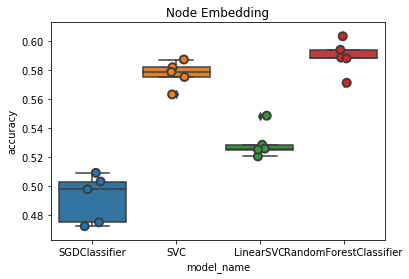

In [75]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_model_df_node) #boxplot to see which model performs better
sns.stripplot(x='model_name', y='accuracy', data=cv_model_df_node, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title("Node Embedding")
plt.show()

In [66]:
# Training: Using 4 different models and 5 fold cross validation to see which one is better
models = [
    SGDClassifier(),
    SVC(),
    LinearSVC(),
    RandomForestClassifier()
    
] 
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models))) #adding them in the df
entries = []
for models in models:
     model_name = models.__class__.__name__
     accuracies = cross_val_score(models, x_train_text, y_train_text, scoring='accuracy', cv=CV) #finding accuracies
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_model_df_text = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_model_df_text

,model_name,fold_idx,accuracy
0,SGDClassifier,0,0.714286
1,SGDClassifier,1,0.730307
2,SGDClassifier,2,0.758344
3,SGDClassifier,3,0.727637
4,SGDClassifier,4,0.740642
5,SVC,0,0.672897
6,SVC,1,0.698264
7,SVC,2,0.722296
8,SVC,3,0.703605
9,SVC,4,0.703209


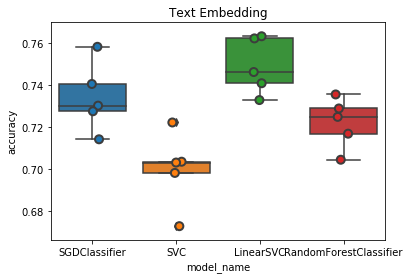

In [76]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_model_df_text) #boxplot to see which model performs better
sns.stripplot(x='model_name', y='accuracy', data=cv_model_df_text, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title("Text Embedding")
plt.show()

In [70]:
# Training: Using 4 different models and 5 fold cross validation to see which one is better
models = [
    SGDClassifier(),
    SVC(),
    LinearSVC(),
    RandomForestClassifier()
    
] 
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models))) #adding them in the df
entries = []
for models in models:
    model_name = models.__class__.__name__
    accuracies = cross_val_score(models, x_train_full, y_train_full, scoring='accuracy', cv=CV) #finding accuracies
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_model_df_full = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_model_df_full

,model_name,fold_idx,accuracy
0,SGDClassifier,0,0.687583
1,SGDClassifier,1,0.663551
2,SGDClassifier,2,0.684913
3,SGDClassifier,3,0.674232
4,SGDClassifier,4,0.685829
5,SVC,0,0.598131
6,SVC,1,0.616822
7,SVC,2,0.590120
8,SVC,3,0.611482
9,SVC,4,0.592246


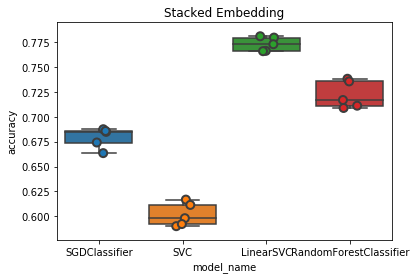

In [77]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_model_df_full) #boxplot to see which model performs better
sns.stripplot(x='model_name', y='accuracy', data=cv_model_df_full, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title("Stacked Embedding")
plt.show()

### 2.6 Classifier Model building  & Prediction

Based on the all the other techniques we could infer that the Linear SVC is the most accurate model with less distortion, therefore it is used to build the node classifiers for all nodes in the network.Then with classifier model, we predict the for the test set

In [72]:
clf=LinearSVC()
model_name = clf.__class__.__name__
clf.fit(x_train_full, y_train_full)
print(model_name,'\n')
# Do the prediction
y_predict=clf.predict(x_test_full)


LinearSVC 



### 2.7 Model Metrics

With the true value and predicted value , we can calculate the metrics like accuracy,f1score,matthews correlation coefficient of this classifier model.The classification report is also generated in order to know the metrics based on each classes.


With the true value and predicted value, we can calculate the metrics like accuracy, f1score, Matthews correlation coefficient of this classifier model. The **accuracy** is **78.37%**. Also, the label wise classification is also generated. **Recall** provides us with the true positive predictions, or the **sensitivity** and we can find that its values is **0.744** which indicates there is good number of positive predictions. **Precision** provides with the exactness of the classifier model and its value is **0.78** which means it has more True positives than  False positives so our model is more exact.**F1 score** is harmonic mean of precision and recall therefore it is very important metric to be considered while building a classifier model, When it is high and almost equal to 1 it would be a best model. For us in this case we have a **0.75**, which is a very good score. The classification report below just provides us the metrics based on each of the classification labels or number of classes in which the data must be classified.

In [73]:
print("Confusion Matrix\n",confusion_matrix(y_test_full,y_predict),'\n')
recall=recall_score(y_test_full,y_predict,average='macro')
precision=precision_score(y_test_full,y_predict,average='macro')
f1score=f1_score(y_test_full,y_predict,average='macro')
accuracy=accuracy_score(y_test_full,y_predict)
matthews = matthews_corrcoef(y_test_full,y_predict) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('Matthews Correlation Coeficient:'+ str(matthews))

Confusion Matrix
 [[3981   85  327   98  135]
 [  80 2790  138  125    8]
 [ 628  237 2539  139   46]
 [ 110  174  101 1777   11]
 [ 577   56  106   57  651]] 

Accuracy: 0.7837873931623932
Macro Precision: 0.7880486309685482
Macro Recall: 0.744784406496015
Macro F1 score:0.7567112445083765
Matthews Correlation Coeficient:0.7194464325515394


In [74]:
from sklearn.metrics import classification_report
target_names=['label 0','label 1','label 2','label 3','label 4']
print("Classification Report\n",classification_report(y_test_full, y_predict, target_names=target_names))

Classification Report
               precision    recall  f1-score   support

     label 0       0.74      0.86      0.80      4626
     label 1       0.83      0.89      0.86      3141
     label 2       0.79      0.71      0.75      3589
     label 3       0.81      0.82      0.81      2173
     label 4       0.76      0.45      0.57      1447

    accuracy                           0.78     14976
   macro avg       0.79      0.74      0.76     14976
weighted avg       0.78      0.78      0.78     14976



## 3. References:



#### RECOMMENDER SYSTEMS:

- https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
- https://github.com/AZG0404/Collaborative-Filtering-for-Implicit-Feedback-Datasets/blob/master/collaborative-filtering-for-implicit-feedback-datasets.ipynb
- https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a
- https://github.com/luisds95/Playground/blob/master/Recommendation%20Systems/Amazon%20Finefoods%20reviews.ipynb
- http://www.diva-portal.se/smash/get/diva2:1111045/FULLTEXT01.pdf
- https://github.com/akhilesh-reddy/Implicit-data-based-recommendation-system/blob/master/Implicit%20data%20based%20recommendation%20system%20using%20ALS.ipynb 
- https://implicit.readthedocs.io/en/latest/lmf.html
- https://github.com/raviraju/recommender_system/tree/master/binary_recommender/articles_recommender/notebooks
- https://implicit.readthedocs.io/en/latest/bpr.html
- https://medium.com/@deepvaghani/understanding-basic-recommendation-systems-using-python-5ee1981601e9#:~:text=AUC%20computes%20the%20area%20under,against%20the%20false%20positive%20rate.&text=A%20classifier%20with%20no%20power,on%20the%20x%3Dy%20diagonal.
- https://stackoverflow.com/questions/41757653/how-to-compute-aucarea-under-curve-for-recommendation-system-evaluation
- https://towardsdatascience.com/recommender-system-using-bayesian-personalized-ranking-d30e98bba0b9#:~:text=Instead%20it%20optimizes%20to%20predict,personalized%20rankings%20for%20each%20user
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


#### NODE CLASSIFICATION:

- https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf
- http://snap.stanford.edu/proj/embeddings-www/files/nrltutorial-part1-embeddings.pdf
- https://scipython.com/book/chapter-6-numpy/examples/vstack-and-hstack/
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.hstack.html
- https://towardsdatascience.com/understanding-word-embeddings-with-tf-idf-and-glove-8acb63892032
- https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
- https://scikit-learn.org/stable/modules/sgd.html
- https://stackoverflow.com/questions/14616519/how-to-remove-a-list-within-list-based-on-len-in-python
- https://kite.com/python/answers/how-to-convert-each-line-in-a-text-file-into-a-list-in-python
- https://medium.com/@contactsunny/how-to-split-your-dataset-to-train-and-test-datasets-using-scikit-learn-e7cf6eb5e0d
- https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-node-classification.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html